# HLOC NetVLAD Testing

In [1]:
%load_ext autoreload

In [2]:
# Check if we have NVidia Driver installed !
!nvidia-smi

Wed Jun  5 19:51:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:41:00.0 Off |                  N/A |
| 38%   60C    P2            139W /  420W |     945MiB /  24576MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Import Stuff

In [3]:
# Imports
# Date Time
from dateutil import tz
from datetime import datetime

# Libraries
import sys
import os
import copy
import json
import numpy as np
import shutil
import PIL

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets, metrics

# PYTORCH !
import torch
import torchinfo
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Visualization
%matplotlib widget
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from torch.utils.tensorboard import SummaryWriter

# Path for Import Internal Modules
sys.path.append("/workspace/fisheye-vpr")


2024-06-05 19:51:06.729057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 19:51:07.652199: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Fix Seed for Reproducablity

In [4]:
# Fixxxing the Seed !
torch.manual_seed(666)

---

### Import Model

In [5]:
# Main Model
from models.vpr_model import VPRModel

# Feature Extractor
from models.encoders.vgg16 import VGG16Encoder

# Clustering
from models.clustering.hloc_netvlad import NetVLAD

# Loss
from models.loss_function.HardTripletLoss import HardTripletLoss

# Trainer
from util.train import Trainer

---

### Dataset Selection

In [6]:
# Import Dataset Class
from dataloaders.eng3_floor1_fisheye import ENG3_Floor1_Fisheye_Dataset

# Create Dataset Instance
dataset = ENG3_Floor1_Fisheye_Dataset()


---

###  Dataset Exploring

In [7]:
import util.notebook_util as notebook_util

(2, 2)


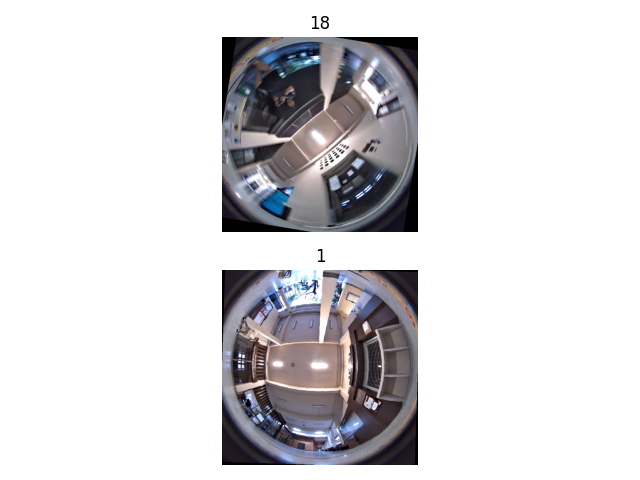

In [12]:
# Display the output
train_batch = next(iter(dataset.train_dataloader))
train_class = dataset.dataset.classes
notebook_util.visualize_batch(train_batch, train_class, header="train batch")

In [13]:
# Reload Dataset
dataset = ENG3_Floor1_Fisheye_Dataset()

---

### Model Assembling

In [14]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

# Matlab Layer weights
from scipy.io import loadmat


encoder = vgg16(
            weights=VGG16_Weights.IMAGENET1K_V1
        )

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:48<00:00, 11.3MB/s] 


In [25]:
encoder.features == list(encoder.children())[0]

True

In [38]:
nn.Sequential(*list(list(encoder.children())[0].children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [41]:
nn.Sequential(
    *list(encoder.features)[:-2]
)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [26]:
nn.Sequential(*list(encoder.features.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [19]:
torchinfo.summary(encoder)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

In [ ]:
# Create the Encoder
encoder = VGG16Encoder()

# Load the Checkpoint for Encoder
encoder.